<a href="https://colab.research.google.com/github/heokwon/Data-Handling-for-segmentation/blob/main/Laplacian_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Reference : https://www.kaggle.com/code/nghihuynh/data-augmentation-laplacian-pyramid-blending, https://github.com/twyunting/Laplacian-Pyramids

# Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imageio
import tifffile as tiff
from PIL import Image
import numpy as np
import seaborn as sns
import scipy.signal as sig
from scipy import misc
import matplotlib.pyplot as plt
from scipy import ndimage
import random

# Load Gaussian Kernel

In [2]:
kernel = (1.0/256)*np.array([[1, 4, 6, 4, 1],[4, 16, 24, 16, 4],[6, 24, 36, 24, 6],[4, 16, 24, 16, 4],[1, 4, 6, 4, 1]])

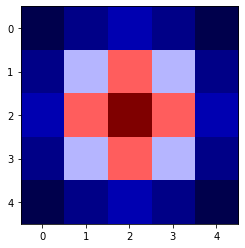

In [3]:
plt.imshow(kernel, cmap='seismic')
plt.show()

In [4]:
kernel.shape

(5, 5)

# Gaussian-Laplacian blending

In [5]:
# https://github.com/twyunting/Laplacian-Pyramids


def interpolate(image):
    """
    Interpolates an image with upsampling rate r = 2
    """
    image_up = np.zeros((2*image.shape[0], 2*image.shape[1]))
    # Upsample
    image_up[::2, ::2] = image
    # Blur (we need to scale this up since the kernel has unit area)
    # (The length and width are both doubled, so the area is quadrupled)
    #return sig.convolve2d(image_up, 4*kernel, 'same')
    return ndimage.filters.convolve(image_up,4*kernel, mode='constant')
                                
def decimate(image):
    """
    Decimates an image with downsampling rate r=2.
    """
    image_blur = ndimage.filters.convolve(image,kernel, mode='constant')
    # Downsample
    return image_blur[::2, ::2]                                
               
                                      
# here is the constructions of pyramids
def pyramids(image):
    """
    Constructs Gaussian and Laplacian pyramids.
    Parameters :
    image  : the original image (i.e. base of the pyramid)
    Returns :
    G   : the Gaussian pyramid
    L   : the Laplacian pyramid
    """
    # Initialize pyramids
    G = [image, ]
    L = []

    # Build the Gaussian pyramid to maximum depth
    while image.shape[0] >= 4 and image.shape[1] >= 4:
        image = decimate(image)
        G.append(image)

   # Build the Laplacian pyramid
    for i in range(len(G) - 1):
        L.append(G[i] - interpolate(G[i + 1]))

    return G[:-1], L


# Build Gaussian pyramid and Laplacian pyramids from images A and B, also mask
# Reference: https://becominghuman.ai/image-blending-using-laplacian-pyramids-2f8e9982077f
def pyramidBlending(A, B, mask):
    [GA, LA] = pyramids(A)
    [GB ,LB] = pyramids(B)
    # Build a Gaussian pyramid GR from selected region R (mask that says which pixels come from left and which from right)
    [Gmask, LMask] = pyramids(mask)
    # Form a combined pyramid LS from LA and LB using nodes of GR as weights
    # Equation: LS(i, j) = GR(I, j)*LA(I, j) + (1-GR(I, j)* LB(I, j))
    # Collapse the LS pyramid to get the final blended image
    blend = []
    for i in range(len(LA)):
        # LS = np.max(Gmask[i])*LA[i] + (1-np.max(Gmask[i]))*LB[i]
        # make sure the color with in 255 (white)
        LS = Gmask[i]/255*LA[i] + (1-Gmask[i]/255)*LB[i]
        blend.append(LS)
    return blend

# reconstruct the pyramids as well as upsampling and add up with each level
def reconstruct(pyramid):
    rows, cols = pyramid[0].shape
    res = np.zeros((rows, cols + cols//2), dtype= np.double)
    # start the smallest pyramid so we need to reverse the order
    revPyramid = pyramid[::-1]
    stack = revPyramid[0]
    # start with the second index
    for i in range(1, len(revPyramid)):
        stack = interpolate(stack) + revPyramid[i] # upsampling simultaneously
    return stack
   
# https://compvisionlab.wordpress.com/2013/05/13/image-blending-using-pyramid/
# Besides pyramid Blending, we need to blend image's color
def colorBlending(img1, img2, mask, organ, i=0):
    # split to 3 basic color, then using pyramidBlending and reconstruct it, respectively
    img1R,img1G,img1B = cv2.split(img1)
    img2R,img2G,img2B = cv2.split(img2)
    # reconstruct each color channel and convert to uint8 to return proper img
    R = reconstruct(pyramidBlending(img1R, img2R, mask))
    G = reconstruct(pyramidBlending(img1G, img2G, mask))
    B = reconstruct(pyramidBlending(img1B, img2B, mask))
    output = cv2.merge((R, G, B))#.astype('uint8')
    imageio.imsave(f"output_{organ}_{i}.png", output)
    img = cv2.imread(f"output_{organ}_{i}.png")
    #img = imageio.v2.imread("output.png")
    return img
    
def Blending_mask(mask1, mask2, mask0, organ, i=0):
#     mask2 = mask2.resize(mask1.size)
    mask00 = imageio.imsave("output_mask.png", mask0)
    mask00 = Image.open("output_mask.png")
    output = Image.composite(mask1, mask2, mask00)
    output = output.save(f"output_mask_{organ}_{i}.png")
    output = Image.open(f"output_mask_{organ}_{i}.png")
    return output


In [6]:
# train csv
!gdown 1CYzwew45Tuzs1w0oNbraDT4F8RoMlq1O

Downloading...
From: https://drive.google.com/uc?id=1CYzwew45Tuzs1w0oNbraDT4F8RoMlq1O
To: /content/train.csv
100% 16.4M/16.4M [00:00<00:00, 170MB/s]


In [7]:
data_frame = pd.read_csv('/content/train.csv')

## Save Image

In [ ]:
!gdown 1vuUOo20n4Re0LZzJf-Xa248Cho4bZ0Lv
!unzip /content/LPB_768_r2_dataset.zip

In [ ]:
#@title
# !mv /content/512x512_Binary/512x512_images /content/512x512_Binary/512x512_images_jpg
# !mkdir /content/512x512_Binary/512x512_images

In [ ]:
#@title
# ## jpg2png
# import os
# from PIL import Image
# src='/content/512x512_Binary/512x512_images_jpg/'
# des='/content/512x512_Binary/512x512_images/'
# for img in os.listdir(src):
#     img_dir=os.path.join(src,img)
#     pngs=Image.open(img_dir)
#     pngs.save(des+img[:-4]+'.png')

In [ ]:
#@title
# !rm -rf /content/512x512_Binary/512x512_images_jpg

In [10]:
# !rm -rf test
!mkdir test
!mkdir /content/test/images
!mkdir /content/test/masks

In [12]:
len(os.listdir('/content/lpb_conv_768_r2_dataset/images')),len(os.listdir('/content/lpb_conv_768_r2_dataset/masks'))

(2788, 2788)

In [13]:
## helper function
def highlight(row):
    df = lambda x: ['background: #CCCCFF' if x.name in row
                        else '' for i in x]
    return df

def list_ids_organ(df, o):
    """
    Args: 
        df: dataframe
        o: specific organ 
    
    Returns:
        list_ids: list of ids based on organ
    """
    list_ids = list(df.loc[df['organ']==o].id)
    return list_ids

In [14]:
# create an organ dataframe with ids only
organs = {'prostate': [],'spleen': [],'lung': [],'kidney': [],'largeintestine': []}
for organ, ids in organs.items():
    list_organ = list_ids_organ(data_frame, organ)
    ids.append(list_organ)
df_organs = pd.DataFrame.from_dict(organs, orient='index').reset_index()
df_organs.columns = ['organ', 'ids']
df_organs

,organ,ids
0,prostate,"[10044, 10274, 10666, 10912, 10971, 1184, 1223..."
1,spleen,"[10392, 10610, 10703, 10992, 1123, 11448, 1164..."
2,lung,"[10488, 11064, 11629, 1220, 12452, 12476, 127,..."
3,kidney,"[10611, 11497, 1157, 12784, 13034, 13260, 1475..."
4,largeintestine,"[10651, 10892, 11662, 1168, 11890, 12174, 1247..."


In [15]:
prostate = df_organs.loc[df_organs['organ'] == 'prostate']['ids'].values[0]
spleen = df_organs.loc[df_organs['organ'] == 'spleen']['ids'].values[0]
lung = df_organs.loc[df_organs['organ'] == 'lung']['ids'].values[0]
kidney = df_organs.loc[df_organs['organ'] == 'kidney']['ids'].values[0]
largeintestine = df_organs.loc[df_organs['organ'] == 'largeintestine']['ids'].values[0]

In [16]:
import random

In [17]:
def saveBlending(img1, img2, mask, path):
    # split to 3 basic color, then using pyramidBlending and reconstruct it, respectively
    img1R,img1G,img1B = cv2.split(img1)
    img2R,img2G,img2B = cv2.split(img2)
    # reconstruct each color channel and convert to uint8 to return proper img
    R = reconstruct(pyramidBlending(img1R, img2R, mask))
    G = reconstruct(pyramidBlending(img1G, img2G, mask))
    B = reconstruct(pyramidBlending(img1B, img2B, mask))
    output = cv2.merge((R, G, B))#.astype('uint8')
    imageio.imsave(path, output)

In [ ]:
mask = np.zeros((768,768))
mask[:, 384:] = 255
for organ in [prostate, spleen, largeintestine, kidney, lung]:
    random.shuffle(organ)
    # print(organ)
    for idx in range(len(organ)-1):
        img1 = imageio.imread(f'/content/lpb_conv_768_r2_dataset/images/{organ[idx]}_0003.png')
        img2 = imageio.imread(f'/content/lpb_conv_768_r2_dataset/images/{organ[idx+1]}_0003.png')
        path = f'/content/lpb_conv_768_r2_dataset/images/{organ[idx]}_0011.png'
        saveBlending(img1, img2, mask, path)

        mask1 = cv2.imread(f'/content/lpb_conv_768_r2_dataset/masks/{organ[idx]}_0003.png',cv2.IMREAD_GRAYSCALE)
        mask2 = cv2.imread(f'/content/lpb_conv_768_r2_dataset/masks/{organ[idx+1]}_0003.png',cv2.IMREAD_GRAYSCALE)
        
        mask[:, :384] = mask2[:, :384]
        mask[:, 384:] = mask1[:, 384:]
        cv2.imwrite(f'/content/lpb_conv_768_r2_dataset/masks/{organ[idx]}_0011.png', mask)

In [26]:
len(os.listdir('/content/lpb_conv_768_r2_dataset/images')),len(os.listdir('/content/lpb_conv_768_r2_dataset/masks'))

(4172, 4172)

In [51]:
#@title
# for organ in [prostate, spleen, largeintestine, kidney, lung]:
#     for idx in range(len(organ)-1):       
#         mask = np.zeros((768,768))
#         mask1 = cv2.imread(f'/content/conv_768_r2_dataset/masks/{organ[idx]}_0003.png',cv2.IMREAD_GRAYSCALE)
#         mask2 = cv2.imread(f'/content/conv_768_r2_dataset/masks/{organ[idx+1]}_0003.png',cv2.IMREAD_GRAYSCALE)
        
#         mask[:, :384] = mask2[:, :384]
#         mask[:, 384:] = mask1[:, 384:]
#         cv2.imwrite(f'/content/conv_768_r2_dataset/masks/{organ[idx]}_0007.png', mask)

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


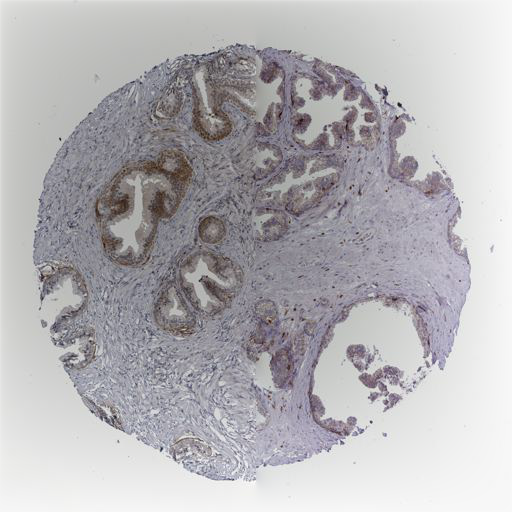

In [ ]:
test_img=Image.open("/content/test/images/10044_0001.png")
test_img

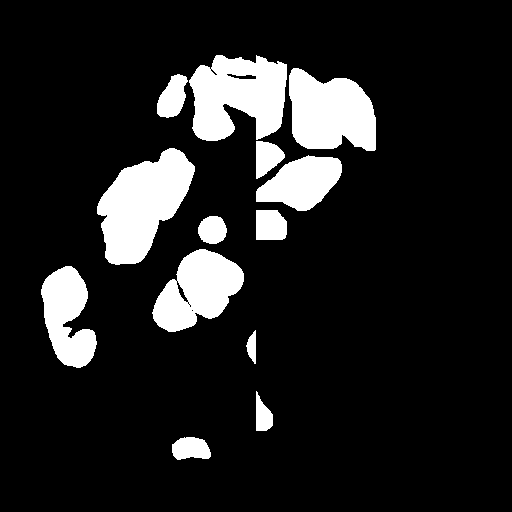

In [ ]:
from PIL import Image
test=Image.open("/content/test/masks/10044_0001.png")
test=np.array(test)
test=test*255
test=Image.fromarray(test)
test

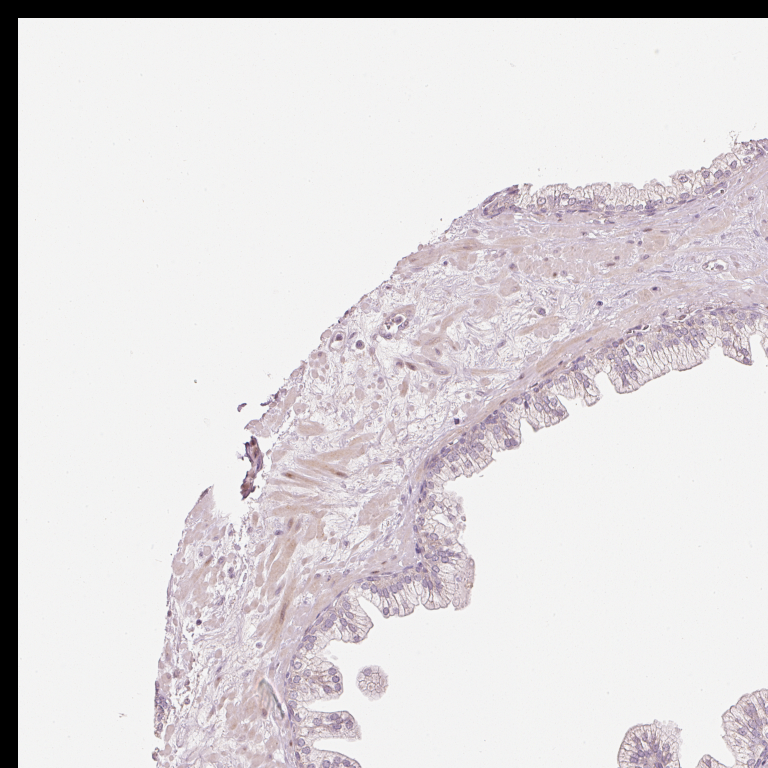

In [22]:
a=Image.open("/content/conv_768_r2_dataset/images/22059_0000.png")
a